# Trabalho Prático 1 - Composição Chroma Key

### Grupo:

- Felipe Seppe <br>
- Luan Franco <br>
- Mateus Figueiredo

## Sumário


## Imports

Junto com os imports necessários, definimos os valores de cada posição RGBA, para melhor leitura do código.

In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from scipy.ndimage import imread
from scipy.misc import imsave

RED, GREEN, BLUE, BRIGHT = (0, 1, 2, 3)

## Funções básicas

No bloco a seguir, implementamos funções básicas para que o processo de chroma key e a inserção da imagem "sem fundo" na imagem de background.

#### Remove_green
   Para retirarmos o fundo verde, vamos zerar o brilho desses pixels. 
Para isso, primeiro conseguimos a intensidade de cada pixel nas camadas RGB e salvamos em suas respectivas matrizes. Entao criamos a relação entre vermelho x verde e azul x verde, nessa relação os pixels a serem removidos serão negativos. Iremos então executar um tipo de binarização, assim como na operação radiométrica, onde os pixels com um brilho maior que um certo valor serão maximizados e os menores serão zerados.
Feito isso, teremos zerado os pixels verdes do fundo.

#### Blend
O processo principal, de inserir a imagem sem fundo na imagem de background é simples. Inserimos no background apenas os pixels com o brilho maior que 0.
Na função Blend também fazemos algumas operações geométricas: o escalamento, rotação e refletimos horizontalmente.

In [2]:
def remove_green(img):
    '''
    objetivo: zerar o brilho dos pixels verdes do fundo.
    '''
    ratio = 255
    '''
    obter a intensidade de
    cada camada
    '''
    red = img[:,:,RED]/ratio
    green = img[:,:,GREEN]/ratio
    blue = img[:,:,BLUE]/ratio

    '''
    com isso, os pixels mais escuros estao proximos de 0
    para evitar remover os negativos pequenos, adicionamos uma
    constante pequena para torna-los positivos
    '''
    redxgreen = (red - green) + 0.55
    bluexgreen = (blue - green) + 0.55

    '''
    pixels menores que 0 são os verdes 
    do fundo que queremos remover
    '''
    for i in range(redxgreen.shape[0]):
        for j in range(redxgreen.shape[1]):
            if(redxgreen[i,j] < 0):
                redxgreen[i,j] = 0
                
    for i in range(bluexgreen.shape[0]):
        for j in range(bluexgreen.shape[1]):
            if(bluexgreen[i,j] < 0):
                bluexgreen[i,j] = 0
                
    '''
    combinar o red x green com o blue x green para gerar
    a nova camada de brilho com valores validos
    '''
    bright = (redxgreen + bluexgreen) * ratio
    
    for i in range(bright.shape[0]):
        for j in range(bright.shape[1]):
            if(bright[i,j] > ratio/3):
                bright[i,j] = ratio
            else:
                bright[i,j] = 0

    img[:,:,BRIGHT] = bright

    return img

'''
compoe as imagens com o fundo
pos = x,y inicial da img
scale = escalar para ampliar/reduzir a image
rotate = angulo que a imagem sera rotacionada
'''
def blend(bg, img, pos=(0,0), scale=None, rotate=None, reflect=None):

    treshhold = 1

    if(scale != None):
        img = sk.transform.rescale(img, scale)
    if(rotate != None):
        img = sk.transform.rotate(img, rotate)
    if(reflect != None):
        img = np.fliplr(img)

    x_ini = pos[0]
    y_ini = pos[1]

    x_fim = x_ini + img.shape[0]
    y_fim = y_ini + img.shape[1]

    if(x_fim > bg.shape[0]): # impedindo que x ou y ultrapassem o tamanho do background
        x_fim = bg.shape[0]
    if(y_fim > bg.shape[1]):
        y_fim = bg.shape[1]

    img = sk.img_as_ubyte(img)

    for i in range(x_ini, x_fim):
        for j in range(y_ini, y_fim):
            if(img[i-x_ini, j-y_ini, BRIGHT] > 0):
                bg[i,j,:] = img[i-x_ini,j-y_ini,:]
    return bg


## Funções dos filtros

Os filtros são aplicados fazendo a convolução do kernel em cada camada R, G e B da imagem, separadamente.

#### Blurring (Passa-baixas)
O filtro de blurring é dado pelo kernel $K$, tal que $ K = \frac{1}{16} * \begin{bmatrix}  1 & 2 & 1 \\
                                                                                           2 & 4 & 2 \\
                                                                                           1 & 2 & 1 \end{bmatrix}$ 

#### Realce 
O filtro de realce é dado pelo kernel $K$, tal que $ K = \begin{bmatrix}  1 & -2 & 1 \\
                                                        -2 & 5 & -2 \\
                                                        1 & -2 &  1 \end{bmatrix}$ 

In [3]:
def blurring(image):
    img = image.copy()
    kernel = np.array([[1, 2, 1],
                       [2, 4, 2],
                       [1, 2, 1]])
    mult = 1/16
    for i in range(3):
        img[:-2,:-2,i] = convolucao(img[:,:,i], kernel, mult)
    return img


def realce(image):
    img = image.copy()
    kernel = np.array([[1, -2, 1],
                       [-2,  5, -2],
                       [1, -2, 1]])
    for i in range(3):
        img[:-2,:-2,i] = convolucao(img[:,:,i], kernel)
    return img

def convolucao(image, kernel, mult=1):
    # por ser uma convolucao, iremos espelhar o filtro
    kernel = np.fliplr(kernel)
    
    image_rows, image_cols = np.shape(image) 
    kernel_rows, kernel_cols = np.shape(kernel) 
    
    # a nova matriz terá uma forma menor que a anterior com base no tamanho do kernel
    result = np.zeros((image_rows-(kernel_rows-1), image_cols-(kernel_cols-1)))
    
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i,j] = np.sum(kernel * image[i:i+kernel_rows, j:j+kernel_cols]) * mult
            if(result[i,j] < 0):
                result[i,j] = 0
    return result

## Funcionamento
Recebemos a imagem de background e todas as outras a serem utilizadas e então removemos o fundo verde delas. Um caso especial é uma imagem com o fundo verde não tão bem feito, que achamos ter uma pequena melhora quando aplicamos o filtro de blurring antes de remover o fundo.

In [4]:
# recebendo imagens a serem utilizadas
bg = imread("imgs/background.jpg", mode = 'RGBA')
c3po = imread("imgs/c3po.jpg", mode = 'RGBA')
falcon = imread("imgs/falcon.jpg", mode = 'RGBA')
galo = imread("imgs/galo1.jpg", mode = 'RGBA')
celular = imread("imgs/celular.jpg", mode = 'RGBA')
skate = imread("imgs/skate.jpg", mode = 'RGBA')
shark = imread("imgs/shark.jpg", mode = 'RGBA')
luan = imread("imgs/luan.png", mode = 'RGBA')
fight = imread("imgs/fight.jpeg", mode = 'RGBA')

remove_green(c3po)
remove_green(falcon)
remove_green(galo)
remove_green(celular)
remove_green(skate)
remove_green(shark)
remove_green(fight)

# aplicando o filtro blurring para diminuir problemas no fundo verde da iamgen 
luan = blurring(luan)
remove_green(luan)
print() # apenas para não printar a matriz 

#### Apenas vendo os resultados ao remover o fundo verde

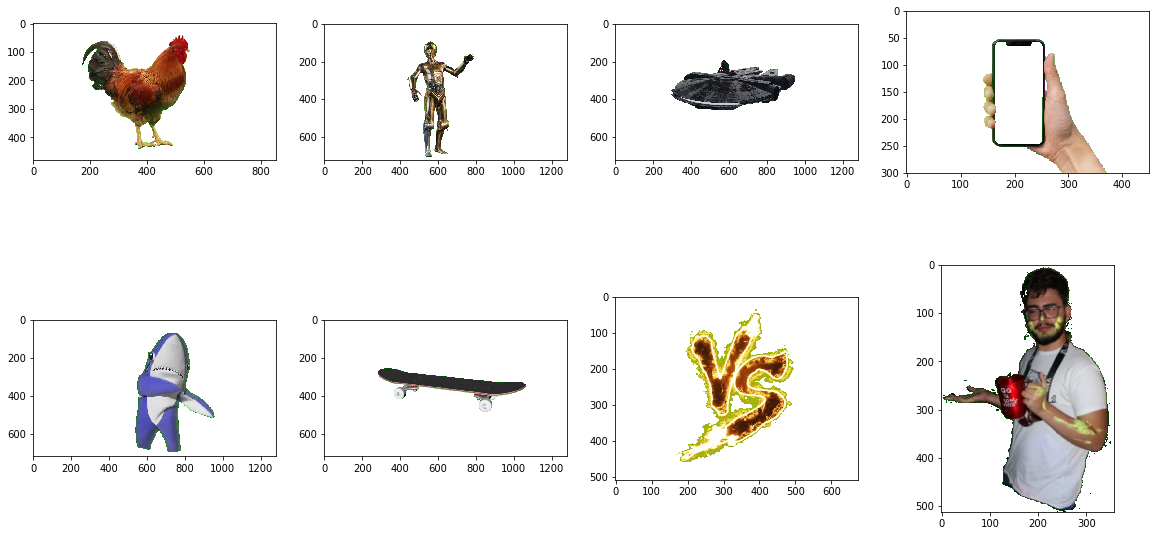

In [5]:
# verificando as imagens sem fundo
fig, (ax1, ax2) = plt.subplots(2, 4)

ax1[0].imshow(galo)
ax1[1].imshow(c3po)
ax1[2].imshow(falcon)
ax1[3].imshow(celular)
ax2[0].imshow(shark)
ax2[1].imshow(skate)
ax2[2].imshow(fight)
ax2[3].imshow(luan)

fig.set_size_inches(20,10)

plt.show(fig)

## Resultados

O bloco abaixo é onde a mágica acontece. Após removermos os fundos das imagens, começamos aplicando alguns filtros em algumas imagens e então chamamos a função __blend__ para inserir a imagem no background. <br>
Ao chamarmos __blend__ fazemos sempre um escalamento na imagem para melhor adequar ao novo fundo.  <br>
Por fim, usamos a funçao __imsave__ para salvar a imagem em disco e plotamos a figura modificada.
Uma observação interessante, se deve à demora em executar a aplicação dos filtros devido ao processo de convolução em 3 dimensões diferentes.

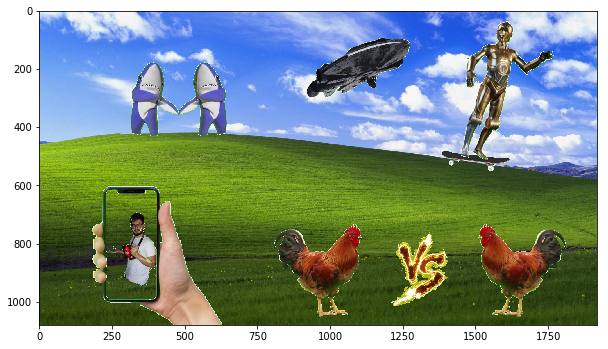

In [6]:
img = bg.copy()

# aplicando filtros (demora mto devido à convoluçao, melhor comentar quando testar as outras coisas)
shark2 = realce(shark)
c3po = blurring(c3po)
galo2 = blurring(galo)

img = blend(img, celular, (500,-100), 2)
img = blend(img, luan, (690,230), 0.5)
img = blend(img, galo, (700,670), 0.8)
img = blend(img, galo2, (700,1270), 0.8, reflect=1)
img = blend(img, fight, (740,1110), 0.6)
img = blend(img, skate, (405,1300), 0.3, 0)
img = blend(img, c3po, (-30,1100), 0.8, -17)
img = blend(img, falcon, (-30, 700), scale=0.6, rotate=200)
img = blend(img, shark, (150,100), 0.4, 0.2)
img = blend(img, shark2, (150,350), 0.4, 0.2, reflect=1)

imsave("outfile.png", img)

fig, ax = plt.subplots(1, 1)
ax.imshow(img)
fig.set_size_inches(10, 10)
plt.show(fig)